# The following notebook demonstatres the evaluation methodolgy for the model.



In [138]:
import utils
import pandas as pd
import keras
import numpy as np

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

TEST_DATA = "test.csv"
TEST_LABELS = "test_labels.csv"
DATA_FIELD = ["id","comment_text"]
LABEL_FIELDS = ["id","toxic","severe_toxic","obscene","threat","insult","identity_hate"]
REDUNDANT_FIELDS = ["id"]

In [121]:
# Load in model
model = utils.build_model(20000)
model.summary()

# make predictions on model
test_data = pd.read_csv(TEST_DATA)
test_labels = pd.read_csv(TEST_LABELS)

# Combine test data and labels into one data frame
test_dataset = pd.concat([test_data, test_labels], axis=1)

# Remove redundant id field 
test_dataset = test_dataset.drop(columns=REDUNDANT_FIELDS)

# Remove samples with labels containing -1 in test dataset, this 
# is a place holder for samples that were not assigned labels.
test_dataset = test_dataset.drop(test_dataset[(test_dataset.toxic == -1) |
                                              (test_dataset.severe_toxic == -1) |
                                              (test_dataset.obscene == -1) |
                                              (test_dataset.threat == -1) |
                                              (test_dataset.insult == -1) |
                                              (test_dataset.identity_hate == -1)].index)

x_test = test_dataset["comment_text"]
y_true = test_dataset[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]]


tokenizer = Tokenizer(20000)
tokenizer.fit_on_texts(x_test)
corpus = tokenizer.word_index
reverse_corpus = dict(map(reversed, corpus.items()))

x_sequences_test = tokenizer.texts_to_sequences(x_test)
x_padded_test = keras.preprocessing.sequence.pad_sequences(x_sequences_test, maxlen= 150)
x_padded_test = np.array(x_padded_test)

print("Shape of test data:", x_padded_test.shape)
print("Shape of test labels:", y_true.shape)

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_35 (Embedding)     (None, None, 128)         2560000   
_________________________________________________________________
dropout_70 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
conv1d_70 (Conv1D)           (None, None, 128)         114816    
_________________________________________________________________
conv1d_71 (Conv1D)           (None, None, 128)         114816    
_________________________________________________________________
global_max_pooling1d_35 (Glo (None, 128)               0         
_________________________________________________________________
dense_70 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_71 (Dropout)         (None, 128)             

# Metrics

- Confusion Matrix
- F1 measure
- Accuracy



In [155]:
from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score
import matplotlib.pyplot as plt

y_pred = model.predict(x_padded_test).round()
y_pred = y_pred.astype(int)

print(y_pred[7])
print(y_true.values[7])
print(y_pred)
print(y_true.values)

f1 = f1_score(y_true.values, y_pred, average='macro')
accuracy = accuracy_score(y_true, y_pred)

print("F1: ", f1)
print("Accuracy: ", accuracy)


[0 0 0 0 0 0]
[0 0 0 0 0 0]
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [1 0 1 0 1 0]
 [0 0 0 0 0 0]]
F1:  0.0
Accuracy:  0.90241958173122


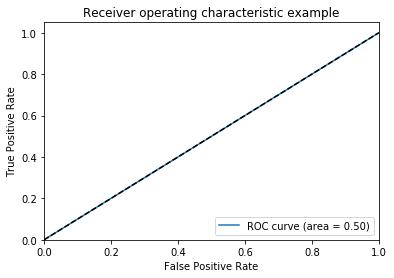

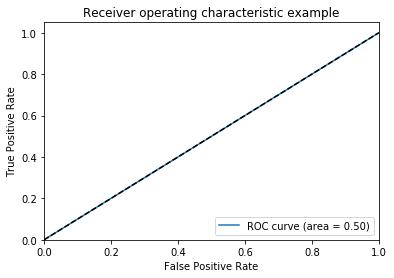

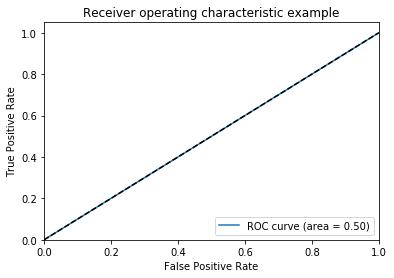

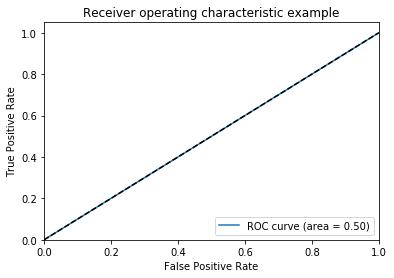

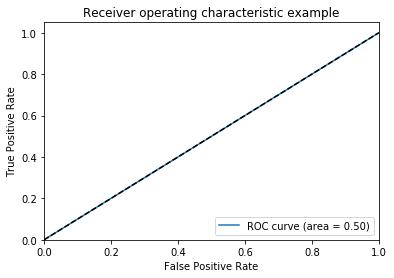

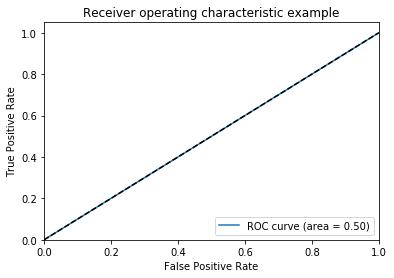

In [154]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(y_true.values[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    

# Plot of a ROC curve for a specific class
for i in range(6):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
